# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [53]:
#Import all the required libraries
#Import all the required libraries
import pandas as pd
import numpy as np
import os
import PIL
import random
import collections
import matplotlib.pyplot as plt
import string 
import glob
from PIL import Image
from matplotlib.pyplot import figure

import tensorflow as tf
from operator import itemgetter
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tqdm import tqdm
import time
from nltk.translate.bleu_score import sentence_bleu






import warnings
warnings.filterwarnings('ignore')


Let's read the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [ ]:
#Import the dataset and read the image into a seperate variable

# Loading The text Data
text_path = '/content/drive/MyDrive/eye_for_blind_data/captions.txt'
text = open(text_path).readlines()

# Loading the images data
img_path = "drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset"
images = os.listdir(img_path)

all_imgs = glob.glob(img_path + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


3626689571_5817f99c0e.jpg,Tall man in red and black stands outside holding basketball .

2486364531_b482d7f521.jpg,Boy wearing a red shirt standing on a plastic object and holding a yellow toy shovel .

2992808092_5f677085b7.jpg,Two boys fight for the ball .

3419238351_ac18b440c0.jpg,A bunch of people watching a child in the bathtub .



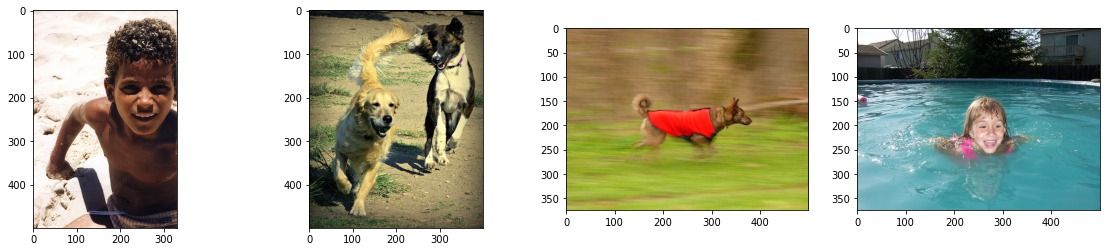

In [ ]:
#Visualise both the images & text present in the dataset

fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)

for _ in range(len(axes)):
  axes[_].imshow(Image.open(random.choice(all_imgs)))

for _ in range(4):
  print(random.choice(text))

In [ ]:
  #Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    text = pd.read_csv(filename)
    return text

text_file = text_path
doc = load_doc(text_file)
print(doc.shape[0])
doc[:10]

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
all_img_id= doc['image']
all_img_vector= [img_path+'/'+_ for _ in all_img_id]
annotations= doc['caption']

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,drive/MyDrive/eye_for_blind_data/Flickr8k_Data...,A rock climber in a red shirt .


In [ ]:
#Create a list which contains all the captions
annotations= list(df['Captions'])

#add the <start> & <end> token to all those captions as well
annotations = ['<start> '+_+' <end>' for _ in annotations]

#Create a list which contains all the path to the images
all_img_path= [img_path+'/'+_ for _ in os.listdir(img_path)]

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [ ]:
#Create the vocabulary & the counter for the captions

def Counter(vocab):
  frequency = collections.Counter(vocab)
  return frequency


def Vocab(text):
  text = text.split(' ')
  text = [_.strip().lower() for _ in text if _ not in string.punctuation]
  return text


vocabulary= Vocab(' '.join(annotations))
val_count = Counter(vocabulary)

df_word = pd.DataFrame.from_dict(val_count, orient='index')
df_word = df_word.sort_values(by=[0],ascending=False).reset_index()
df_word =df_word.rename(columns={'index':'word', 0:'count'})
df_word[0:5]

,word,count
0,a,62986
1,<start>,40455
2,<end>,40455
3,in,18974
4,the,18418


<BarContainer object of 30 artists>

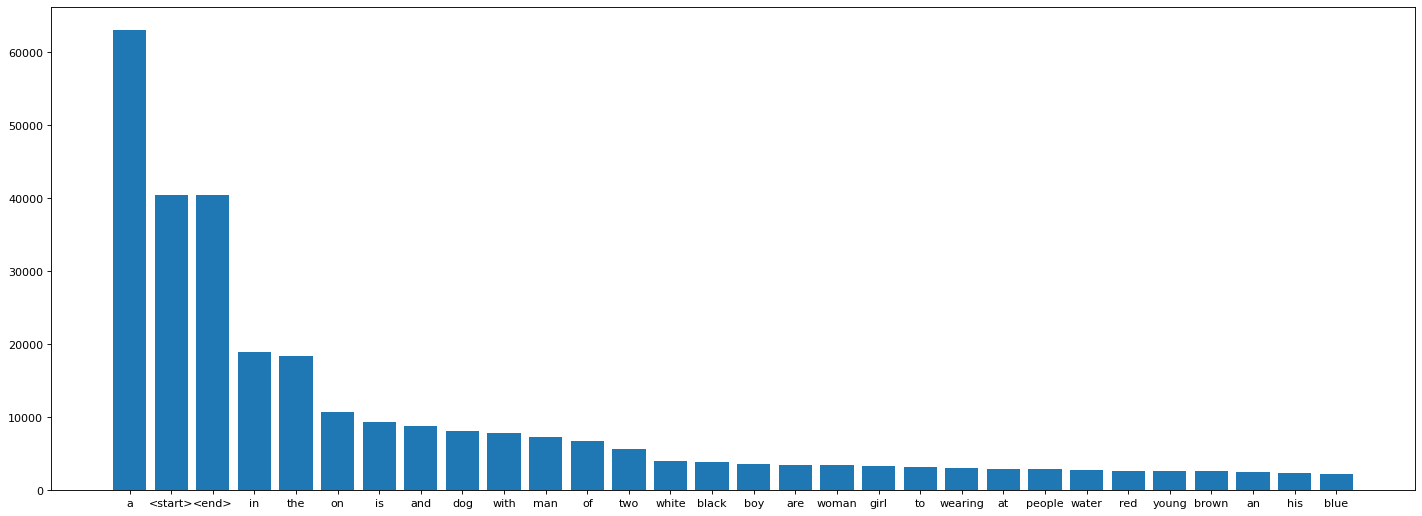

In [ ]:
#Visualise the top 30 occuring words in the captions
figure(figsize=(22, 8), dpi=80)
plt.bar(df_word[:30]['word'],df_word[:30]['count'])

#write your code here

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# create the tokenizer

top_freq_words = 5001
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = top_freq_words,
    filters = string.punctuation.replace('<','').replace('>',''),
    lower=True, split=' ', char_level=False, oov_token="UNK"  
)

tokenizer.fit_on_texts(annotations)

# Create the tokenized vectors
cap_sequences = tokenizer.texts_to_sequences(annotations)
print(cap_sequences[:3]) 


[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4]]


In [ ]:
# Create word-to-index and index-to-word mappings.
def word_to_index(word):
    return tokenizer.word_index[word]
    
def index_to_word(index):
    return tokenizer.index_word[index]

print("index of 'the' is " + str(word_to_index('the')))
print("word of index 7 is '" + str(index_to_word(7)) + "'")

index of 'the' is 6
word of index 7 is 'on'


<BarContainer object of 30 artists>

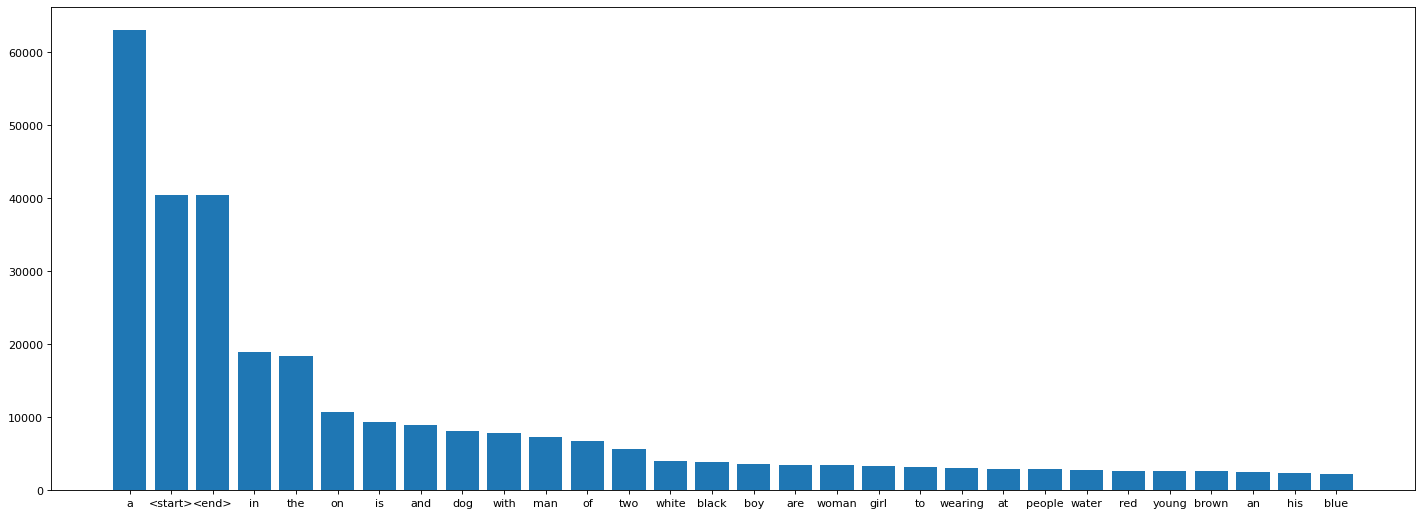

In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

word_count = tokenizer.word_counts
word_count = sorted(word_count.items(), key=itemgetter(1), reverse = True)

figure(figsize=(22, 8), dpi=80)
x = [_[0] for _ in word_count[:30]]
y = [_[1] for _ in word_count[:30]]
plt.bar(x,y)

In [ ]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
max_length = max([len(cap) for cap in cap_sequences])

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_sequences, padding='post')

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

print("The shape of Caption vector is :" + str(cap_vector.shape))
print(cap_vector[:5]) 

word_to_index('PAD')

The shape of Caption vector is :(40455, 39)
[[   3    2   44    5    2   91  173    8  120   52    2  394   13  395
     5   29    1  671    4    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   20  317   65    2  197  118    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20  120   65    2  197 2438    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20  120    6  395   21   61 2438    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   3    2   41   20    5    2   91  173  317   65    2  197 2982    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

0

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
#write your code here to create the dataset consisting of image paths
all_img_path = sorted(set(all_imgs))

In [ ]:
#write your code here for creating the function. This function should return images & their path

def load_image(images):
    #write your pre-processing steps here
    shape = (299, 299)
    img = tf.io.read_file(images)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, images

In [ ]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

print(all_img_path)
img_data = tf.data.Dataset.from_tensor_slices(all_img_path)
img_data = img_data.map(load_image).batch(32)

['drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1003163366_44323f5815.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1007129816_e794419615.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1007320043_627395c3d8.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1009434119_febe49276a.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1012212859_01547e3f17.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1015118661_980735411b.jpg', 'drive/MyDrive/eye_for_blind_data/Flickr8k_Dataset/Flicker8k_Dataset/1015584366_dfcec3c85a.jpg', 'drive/MyDrive/eye_for_blind_

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [ ]:
Iv3 = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = Iv3.input
hidden_layer = Iv3.layers[-1].output

feature_extractor = keras.Model(new_input,hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
feature_dict = {}

for img,path in img_data:
    fv = Iv3(img)
    fv = tf.reshape(fv,(fv.shape[0], -1, fv.shape[3]))
    for bf, pat in zip(fv, path):
        feature_path = pat.numpy().decode("utf-8")
        feature_dict[feature_path] = bf.numpy()


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split( all_img_vector,cap_vector,random_state=50,test_size=0.2)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_path,cap):# your input variable goes here)
  img_tensor = feature_dict[img_path.decode('utf-8')]
  return img_tensor,cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_data,cap_data,BUFFER_SIZE=1000):
    dataset = tf.data.Dataset.from_tensor_slices((img_data,cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset



In [ ]:
train_dataset = gen_dataset(path_train,cap_train)
test_dataset = gen_dataset(path_test,cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
BATCH_SIZE = 32
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation #embedding_dim
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x ,features ,hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state =  self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/eye_for_blind_data/checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))   
            
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps    
    return avg_test_loss

In [41]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.200, & test loss is 1.016
Time taken for 1 epoch 513.0347232818604 sec

Test loss has been reduced from 100.000 to 1.016


  7%|▋         | 1/15 [08:33<1:59:50, 513.61s/it]

For epoch: 2, the train loss is 0.941, & test loss is 0.903
Time taken for 1 epoch 350.524614572525 sec

Test loss has been reduced from 1.016 to 0.903


 13%|█▎        | 2/15 [14:24<1:30:35, 418.11s/it]

For epoch: 3, the train loss is 0.859, & test loss is 0.836
Time taken for 1 epoch 351.74618792533875 sec

Test loss has been reduced from 0.903 to 0.836


 20%|██        | 3/15 [20:17<1:17:36, 388.02s/it]

For epoch: 4, the train loss is 0.799, & test loss is 0.782
Time taken for 1 epoch 351.5722801685333 sec

Test loss has been reduced from 0.836 to 0.782


 27%|██▋       | 4/15 [26:09<1:08:31, 373.81s/it]

For epoch: 5, the train loss is 0.750, & test loss is 0.737
Time taken for 1 epoch 351.46406054496765 sec

Test loss has been reduced from 0.782 to 0.737


 33%|███▎      | 5/15 [32:01<1:00:59, 365.95s/it]

For epoch: 6, the train loss is 0.708, & test loss is 0.696
Time taken for 1 epoch 351.97780752182007 sec

Test loss has been reduced from 0.737 to 0.696


 40%|████      | 6/15 [37:53<54:12, 361.36s/it]  

For epoch: 7, the train loss is 0.672, & test loss is 0.660
Time taken for 1 epoch 351.8647634983063 sec

Test loss has been reduced from 0.696 to 0.660


 47%|████▋     | 7/15 [43:45<47:47, 358.39s/it]

For epoch: 8, the train loss is 0.635, & test loss is 0.627
Time taken for 1 epoch 351.74872183799744 sec

Test loss has been reduced from 0.660 to 0.627


 53%|█████▎    | 8/15 [49:38<41:35, 356.44s/it]

For epoch: 9, the train loss is 0.605, & test loss is 0.597
Time taken for 1 epoch 350.48855805397034 sec

Test loss has been reduced from 0.627 to 0.597


 60%|██████    | 9/15 [55:29<35:28, 354.73s/it]

For epoch: 10, the train loss is 0.576, & test loss is 0.569
Time taken for 1 epoch 351.46787428855896 sec

Test loss has been reduced from 0.597 to 0.569


 67%|██████▋   | 10/15 [1:01:21<29:29, 353.94s/it]

For epoch: 11, the train loss is 0.550, & test loss is 0.544
Time taken for 1 epoch 351.7448718547821 sec

Test loss has been reduced from 0.569 to 0.544


 73%|███████▎  | 11/15 [1:07:13<23:33, 353.41s/it]

For epoch: 12, the train loss is 0.526, & test loss is 0.521
Time taken for 1 epoch 351.6812627315521 sec

Test loss has been reduced from 0.544 to 0.521


 80%|████████  | 12/15 [1:13:05<17:39, 353.08s/it]

For epoch: 13, the train loss is 0.503, & test loss is 0.499
Time taken for 1 epoch 350.5990266799927 sec

Test loss has been reduced from 0.521 to 0.499


 87%|████████▋ | 13/15 [1:18:56<11:44, 352.46s/it]

For epoch: 14, the train loss is 0.485, & test loss is 0.478
Time taken for 1 epoch 351.2602620124817 sec

Test loss has been reduced from 0.499 to 0.478


 93%|█████████▎| 14/15 [1:24:48<05:52, 352.28s/it]

For epoch: 15, the train loss is 0.478, & test loss is 0.460
Time taken for 1 epoch 351.0725197792053 sec

Test loss has been reduced from 0.478 to 0.460


100%|██████████| 15/15 [1:30:40<00:00, 362.68s/it]


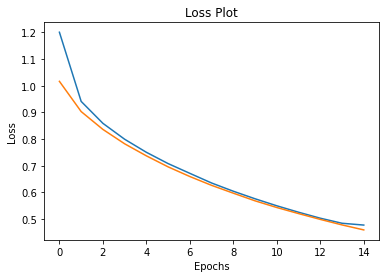

In [42]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [59]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

BELU score: 72.56396362752623
Real Caption: a dog running on grass
Prediction Caption: a brown and white dog runs on the green grass


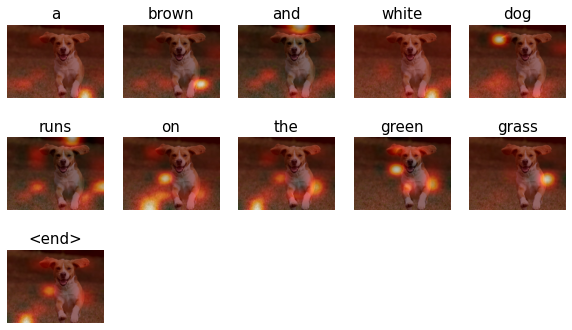

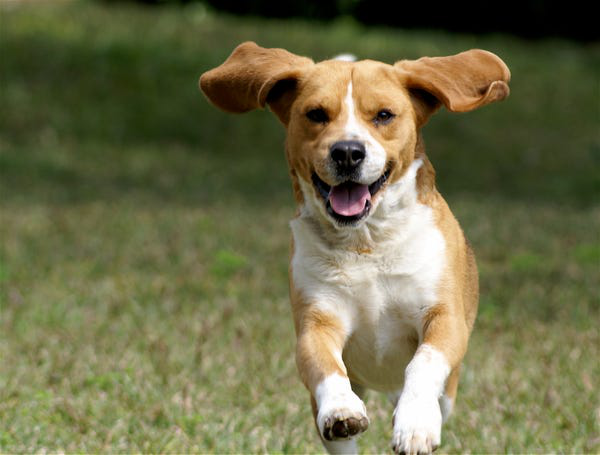

In [65]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = Iv3(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

attention_features_shape = 64
test_image = '/content/drive/MyDrive/eye_for_blind_data/test.jpg'

result, attention_plot,pred_test = evaluate(test_image)
real_caption= 'a dog running on grass'      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
score = sentence_bleu(reference, candidate, weights=(0.35, 0.45, 0.1, 0.1))
print(f"BELU score: {score*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)
Image.open(test_image)